# Implementing Topic Modeling with Amazon Comprehend

## 1. Importing requirements and creating session variables


In [1]:
import boto3
import uuid
# Client and session information
comprehend_client = boto3.client(service_name='comprehend')


# Constants for the S3 bucket and input data file
bucket = 'c144486a3735945l8877744t1w736676914078-labbucket-bszdgpywwmc4'
data_access_role_arn = 'arn:aws:iam::736676914078:role/service-role/c144486a3735945l8877744t1w-ComprehendDataAccessRole-rP2u77TljxYA'


## 2. Importing the newsgroup files

In [2]:
import os
import shutil

data_dir = '20_newsgroups'
if os.path.exists(data_dir):  # Clean up existing data folder
    shutil.rmtree(data_dir)

In [3]:
!tar -xzf ../s3/20_newsgroups.tar.gz
!ls 20_newsgroups

alt.atheism		  rec.autos	      sci.space
comp.graphics		  rec.motorcycles     soc.religion.christian
comp.os.ms-windows.misc   rec.sport.baseball  talk.politics.guns
comp.sys.ibm.pc.hardware  rec.sport.hockey    talk.politics.mideast
comp.sys.mac.hardware	  sci.crypt	      talk.politics.misc
comp.windows.x		  sci.electronics     talk.religion.misc
misc.forsale		  sci.med


In [4]:
folders = [os.path.join(data_dir,f) for f in sorted(os.listdir(data_dir)) if os.path.isdir(os.path.join(data_dir, f))]
file_list = [os.path.join(d,f) for d in folders for f in os.listdir(d)]
print('Number of documents:', len(file_list))

Number of documents: 19997


## 3. Examining and preprocessing the data

In [5]:
!cat 20_newsgroups/comp.graphics/37917

Path: cantaloupe.srv.cs.cmu.edu!crabapple.srv.cs.cmu.edu!fs7.ece.cmu.edu!europa.eng.gtefsd.com!howland.reston.ans.net!usc!elroy.jpl.nasa.gov!nntp-server.caltech.edu!andrey
From: andrey@cco.caltech.edu (Andre T. Yew)
Newsgroups: comp.graphics
Subject: Re: 16 million vs 65 thousand colors
Date: 3 Apr 1993 19:51:06 GMT
Organization: California Institute of Technology, Pasadena
Lines: 28
Message-ID: <1pkpraINNck9@gap.caltech.edu>
References: <1993Mar26.210323.27802@midway.uchicago.edu> <dotzlaw-020493084300@murphy.biochem.umanitoba.ca> <d9hh.733845825@dtek.chalmers.se>
NNTP-Posting-Host: punisher.caltech.edu

d9hh@dtek.chalmers.se (Henrik Harmsen) writes:

>1-4 bits per R/G/B gives horrible machbanding visible in almost any picture.

>5 bits per R/G/B (32768, 65000 colors) gives visible machbanding

>color-gradient picture has _almost_ no machbanding. This color-resolution is 

>see some small machbanding on the smooth color-gradient picture, but all in all,
>There _ARE_ situiations where 

The following functions will remove the headers, quoted text, and footers.

In [6]:
# From sklearn.datasets.twenty_newsgroups import strip_newsgroup_header, strip_newsgroup_quoting, strip_newsgroup_footer
import re
def strip_newsgroup_header(text):
    """
    Given text in "news" format, strip the headers by removing everything
    before the first blank line.
    """
    _before, _blankline, after = text.partition('\n\n')
    return after

_QUOTE_RE = re.compile(r'(writes in|writes:|wrote:|says:|said:'
                       r'|^In article|^Quoted from|^\||^>)')


def strip_newsgroup_quoting(text):
    """
    Given text in "news" format, strip lines beginning with the quote
    characters > or |, plus lines that often introduce a quoted section
    (for example, because they contain the string 'writes:'.)
    """
    good_lines = [line for line in text.split('\n')
                  if not _QUOTE_RE.search(line)]
    return '\n'.join(good_lines)


def strip_newsgroup_footer(text):
    """
    Given text in "news" format, attempt to remove a signature block.

    As a rough heuristic, we assume that signatures are set apart by either
    a blank line or a line made of hyphens, and that it is the last such line
    in the file (disregarding blank lines at the end).
    """
    lines = text.strip().split('\n')
    for line_num in range(len(lines) - 1, -1, -1):
        line = lines[line_num]
        if line.strip().strip('-') == '':
            break

    if line_num > 0:
        return '\n'.join(lines[:line_num])
    else:
        return text

In [7]:
data = []
for f in file_list:
    with open(f, 'rb') as fin:
        content = fin.read().decode('latin1')   
        content = strip_newsgroup_header(content)
        content = strip_newsgroup_quoting(content)
        content = strip_newsgroup_footer(content)
        # remove header, quoting and footer
        data.append(content)

In [8]:
with open('comprehend_input.txt','w', encoding='UTF-8') as cf:
    for line in data:
        line = line.strip()
        line = re.sub('\n',' ',line)
        line = re.sub('\r',' ',line)
        cf.write(line+'\n')

In [9]:
s3 = boto3.resource('s3')
s3.Bucket(bucket).upload_file('comprehend_input.txt', 'comprehend/newsgroups')

In [10]:
number_of_topics = 20

input_s3_url = f"s3://{bucket}/comprehend"
input_doc_format = "ONE_DOC_PER_LINE"
input_data_config = {"S3Uri": input_s3_url, "InputFormat": input_doc_format}

output_s3_url = f"s3://{bucket}/outputfolder/"
output_data_config = {"S3Uri": output_s3_url}

job_uuid = uuid.uuid1()
job_name = f"top-job-{job_uuid}"

print(input_s3_url)

s3://c144486a3735945l8877744t1w736676914078-labbucket-bszdgpywwmc4/comprehend


In [11]:
start_topics_detection_job_result = comprehend_client.start_topics_detection_job(NumberOfTopics=number_of_topics,
                                                                              InputDataConfig=input_data_config,
                                                                              JobName=job_name,
                                                                              OutputDataConfig=output_data_config,
                                                                              DataAccessRoleArn=data_access_role_arn
                                                                            )




In [12]:
# Get current job status
from time import sleep
job = comprehend_client.describe_topics_detection_job(JobId=start_topics_detection_job_result['JobId'])

# Loop until job is completed
waited = 0
timeout_minutes = 40
while job['TopicsDetectionJobProperties']['JobStatus'] != 'COMPLETED':
    sleep(60)
    waited += 60
    assert waited//60 < timeout_minutes, "Job timed out after %d seconds." % waited
    print('.', end='')
    job = comprehend_client.describe_topics_detection_job(JobId=start_topics_detection_job_result['JobId'])

print('Ready')

.............................Ready


In [13]:
topic_comprehend_output_file = job['TopicsDetectionJobProperties']['OutputDataConfig']['S3Uri']
print(f'output filename: {topic_comprehend_output_file}')

topics_comprehend_bucket, topics_comprehend_key = topic_comprehend_output_file.replace("s3://", "").split("/", 1)
print(topics_comprehend_key)
s3r = boto3.resource('s3')
s3r.meta.client.download_file(topics_comprehend_bucket, topics_comprehend_key, 'output.tar.gz')

output filename: s3://c144486a3735945l8877744t1w736676914078-labbucket-bszdgpywwmc4/outputfolder/736676914078-TOPICS-efd78bd52e94b479d93202d533aff60c/output/output.tar.gz
outputfolder/736676914078-TOPICS-efd78bd52e94b479d93202d533aff60c/output/output.tar.gz


In [14]:
# Extract the .tar file
import tarfile
tf = tarfile.open('output.tar.gz')
tf.extractall()

## 4. Analyzing the Amazon Comprehend Events output

In [15]:
import pandas as pd
dftopicterms = pd.read_csv("topic-terms.csv")

In [16]:
dftopicterms.head()

,topic,term,weight
0,0,people,0.031250
1,0,thing,0.011662
2,0,government,0.009719
3,0,force,0.008121
4,0,kill,0.006174


Print each of the topics and the top words for each topic. 

In [17]:
# Selecting rows based on condition
for t in range(0,number_of_topics):
    rslt_df = dftopicterms.loc[dftopicterms['topic'] == t]
    topic_list = rslt_df['term'].values.tolist()
    print(f'Topic {t:2} - {topic_list}')

Topic  0 - ['people', 'thing', 'government', 'force', 'kill', 'live', 'associate', 'gun', 'law', 'moral']
Topic  1 - ['find', 'source', 'information', 'stuff', 'code', 'delete', 'site', 'ftp', 'image', 'advance']
Topic  2 - ['year', 'team', 'ago', 'beat', 'win', 'player', 'play', 'game', 'league', 'season']
Topic  3 - ['work', 'bike', 'bite', 'machine', 'modem', 'suppose', 'port', 'universe', 'version', 'accurately']
Topic  4 - ['program', 'disk', 'read', 'run', 'mac', 'pc', 'book', 'write', 'speed', 'copy']
Topic  5 - ['christian', 'jesus', 'koresh', 'david', 'people', 'claim', 'church', 'christ', 'bible', 'religion']
Topic  6 - ['book', 'read', 'church', 'christian', 'randism', 'write', 'disk', 'jesus', 'article', 'bible']
Topic  7 - ['sell', 'price', 'offer', 'ship', 'include', 'pay', 'condition', 'email', 'buy', 'interest']
Topic  8 - ['post', 'day', 'article', 'read', 'delete', 'stuff', 'group', 'think', 'lot', 'reply']
Topic  9 - ['file', 'format', 'program', 'window', 'convert',

In [18]:
colnames = pd.DataFrame({'topics':['topic 0', 'topic 1', 'topic 2', 'topic 3', 'topic 4', 'topic 5', 'topic 6','topic 7','topic 8','topic 9',
       'topic 10', 'topic 11', 'topic 12', 'topic 13', 'topic 14', 'topic 15', 'topic 16','topic 17','topic 18','topic 19']})

Next, read in the doc-topics.csv file.

In [19]:
dfdoctopics = pd.read_csv("doc-topics.csv")
dfdoctopics.head()

,docname,topic,proportion
0,newsgroups:11,0,1.0
1,newsgroups:46,0,1.0
2,newsgroups:81,5,1.0
3,newsgroups:116,0,1.0
4,newsgroups:151,2,1.0


In [20]:
to_chart = dfdoctopics.loc[dfdoctopics['docname'].isin(['newsgroups:1000','newsgroups:2000','newsgroups:3000','newsgroups:4000','newsgroups:5000'])]

In [21]:
to_chart = to_chart.pivot_table(values='proportion', index='topic', columns='docname')
to_chart.head()

docname,newsgroups:1000,newsgroups:2000,newsgroups:3000,newsgroups:4000,newsgroups:5000
topic,,,,,
3,NaN,NaN,NaN,NaN,0.163439
4,NaN,1.0,NaN,1.0,NaN
10,1.0,NaN,NaN,NaN,NaN
11,NaN,NaN,NaN,NaN,0.314577
13,NaN,NaN,NaN,NaN,0.521984


Text(0.5, 0, 'Topic ID')

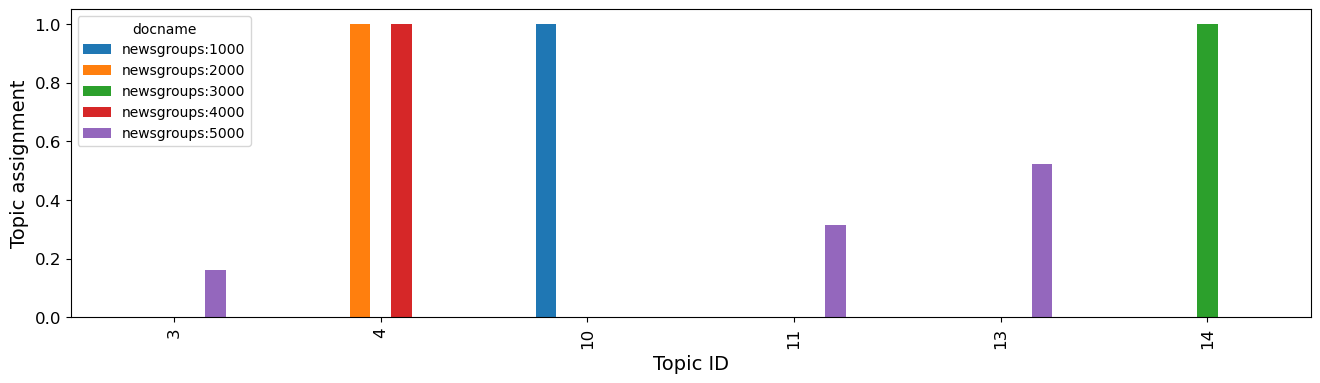

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

fs = 12
# df.index = colnames['topic']
to_chart.plot(kind='bar', figsize=(16,4), fontsize=fs)
plt.ylabel('Topic assignment', fontsize=fs+2)
plt.xlabel('Topic ID', fontsize=fs+2)